# Importing Dependencies

In [71]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import re    # RegEx: Removes non-letter characters
import nltk  # Natural Language Processing
nltk.download("stopwords")
nltk.download("vader_lexicon")
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import datasets
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import History
from tensorflow.keras import losses
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

pd.options.plotting.backend = "plotly"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Loading Dataset

In [3]:
df = pd.read_csv('tweets.csv')
df

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0
...,...,...,...,...,...
11365,11365,wrecked,Blue State in a red sea,Media should have warned us well in advance. T...,0
11366,11366,wrecked,arohaonces,i feel directly attacked 💀 i consider moonbin ...,0
11367,11367,wrecked,🇵🇭,i feel directly attacked 💀 i consider moonbin ...,0
11368,11368,wrecked,auroraborealis,"ok who remember ""outcast"" nd the ""dora"" au?? T...",0


In [4]:
df=df[['text']]
df

,text
0,"Communal violence in Bhainsa, Telangana. ""Ston..."
1,Telangana: Section 144 has been imposed in Bha...
2,Arsonist sets cars ablaze at dealership https:...
3,Arsonist sets cars ablaze at dealership https:...
4,"""Lord Jesus, your love brings freedom and pard..."
...,...
11365,Media should have warned us well in advance. T...
11366,i feel directly attacked 💀 i consider moonbin ...
11367,i feel directly attacked 💀 i consider moonbin ...
11368,"ok who remember ""outcast"" nd the ""dora"" au?? T..."


# Preprocessing

In [38]:
# Convert tweet text into a sequence of words
def tweet_to_words(tweet):
    # Lowercase
    text = tweet.lower()
    # Remove non-letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # Tokenize
    words = text.split()
    # Remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # Return list
    return words

In [103]:
cleantext=[]
for item in tqdm(df['text']):
    words=tweet_to_words(str(item))
    cleantext+=[words]
df['cleantext']=cleantext
df

100%|██████████| 11370/11370 [00:15<00:00, 728.65it/s]


,text,cleantext,vader_neg,vader_neu,vader_pos,vader_comp,cleantext2,class
0,"Communal violence in Bhainsa, Telangana. ""Ston...","[communal, violence, bhainsa, telangana, stone...",0.272,0.728,0.000,-0.6249,communal violence bhainsa telangana stones pel...,0
1,Telangana: Section 144 has been imposed in Bha...,"[telangana, section, 144, imposed, bhainsa, ja...",0.274,0.726,0.000,-0.5994,telangana section 144 imposed bhainsa january ...,0
2,Arsonist sets cars ablaze at dealership https:...,"[arsonist, sets, cars, ablaze, dealership, htt...",0.000,1.000,0.000,0.0000,arsonist sets cars ablaze dealership https co ...,1
3,Arsonist sets cars ablaze at dealership https:...,"[arsonist, sets, cars, ablaze, dealership, htt...",0.000,1.000,0.000,0.0000,arsonist sets cars ablaze dealership https co ...,1
4,"""Lord Jesus, your love brings freedom and pard...","[lord, jesus, love, brings, freedom, pardon, f...",0.000,0.470,0.530,0.9081,lord jesus love brings freedom pardon fill hol...,2
...,...,...,...,...,...,...,...,...
11365,Media should have warned us well in advance. T...,"[media, warned, us, well, advance, wrecked, wh...",0.321,0.522,0.157,-0.2960,media warned us well advance wrecked whole nig...,2
11366,i feel directly attacked 💀 i consider moonbin ...,"[feel, directly, attacked, consider, moonbin, ...",0.448,0.552,0.000,-0.7964,feel directly attacked consider moonbin amp ji...,0
11367,i feel directly attacked 💀 i consider moonbin ...,"[feel, directly, attacked, consider, moonbin, ...",0.384,0.616,0.000,-0.7964,feel directly attacked consider moonbin amp ji...,0
11368,"ok who remember ""outcast"" nd the ""dora"" au?? T...","[ok, remember, outcast, nd, dora, au, au, wrec...",0.096,0.753,0.151,0.2023,ok remember outcast nd dora au au wrecked nerv...,2


In [42]:
# Convert sequence of words into a tweet
def unlist(list):
    words=''
    for item in list:
        words+=item+' '
    return words

In [43]:
# pos -> POSITIVE
# neg -> NEGATIVE
# neu -> NEUTRAL
# compuound -> MIXED
def compute_vader_scores(df, label):
    sid = SentimentIntensityAnalyzer()
    df["vader_neg"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["neg"])
    df["vader_neu"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["neu"])
    df["vader_pos"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["pos"])
    df["vader_comp"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["compound"])
    df['cleantext2'] = df[label].apply(lambda x: unlist(x))
    return df

In [44]:
df_copy = compute_vader_scores(df,'cleantext')
df_copy

,text,cleantext,vader_neg,vader_neu,vader_pos,vader_comp,cleantext2,class
0,"Communal violence in Bhainsa, Telangana. ""Ston...","[communal, violence, bhainsa, telangana, stone...",0.272,0.728,0.000,-0.6249,communal violence bhainsa telangana stones pel...,1
1,Telangana: Section 144 has been imposed in Bha...,"[telangana, section, 144, imposed, bhainsa, ja...",0.274,0.726,0.000,-0.5994,telangana section 144 imposed bhainsa january ...,0
2,Arsonist sets cars ablaze at dealership https:...,"[arsonist, sets, cars, ablaze, dealership, htt...",0.000,1.000,0.000,0.0000,arsonist sets cars ablaze dealership https co ...,1
3,Arsonist sets cars ablaze at dealership https:...,"[arsonist, sets, cars, ablaze, dealership, htt...",0.000,1.000,0.000,0.0000,arsonist sets cars ablaze dealership https co ...,1
4,"""Lord Jesus, your love brings freedom and pard...","[lord, jesus, love, brings, freedom, pardon, f...",0.000,0.470,0.530,0.9081,lord jesus love brings freedom pardon fill hol...,2
...,...,...,...,...,...,...,...,...
11365,Media should have warned us well in advance. T...,"[media, warned, us, well, advance, wrecked, wh...",0.321,0.522,0.157,-0.2960,media warned us well advance wrecked whole nig...,2
11366,i feel directly attacked 💀 i consider moonbin ...,"[feel, directly, attacked, consider, moonbin, ...",0.448,0.552,0.000,-0.7964,feel directly attacked consider moonbin amp ji...,0
11367,i feel directly attacked 💀 i consider moonbin ...,"[feel, directly, attacked, consider, moonbin, ...",0.384,0.616,0.000,-0.7964,feel directly attacked consider moonbin amp ji...,0
11368,"ok who remember ""outcast"" nd the ""dora"" au?? T...","[ok, remember, outcast, nd, dora, au, au, wrec...",0.096,0.753,0.151,0.2023,ok remember outcast nd dora au au wrecked nerv...,2


# Visualization

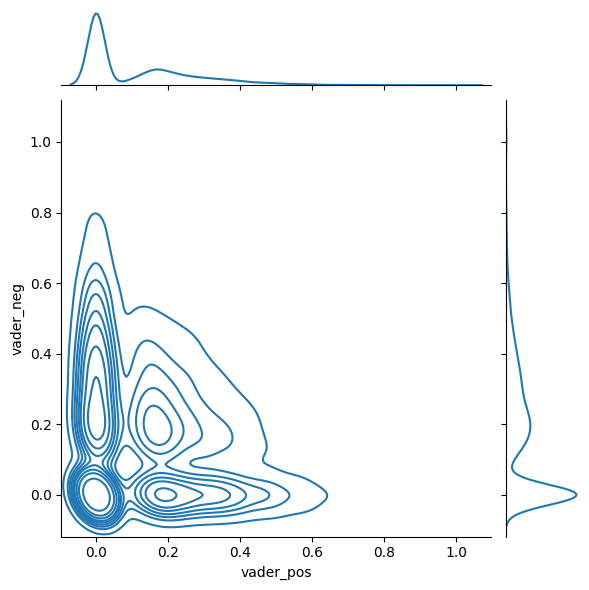

In [45]:
sns.jointplot(data=df_copy, x='vader_pos', y='vader_neg', kind="kde")

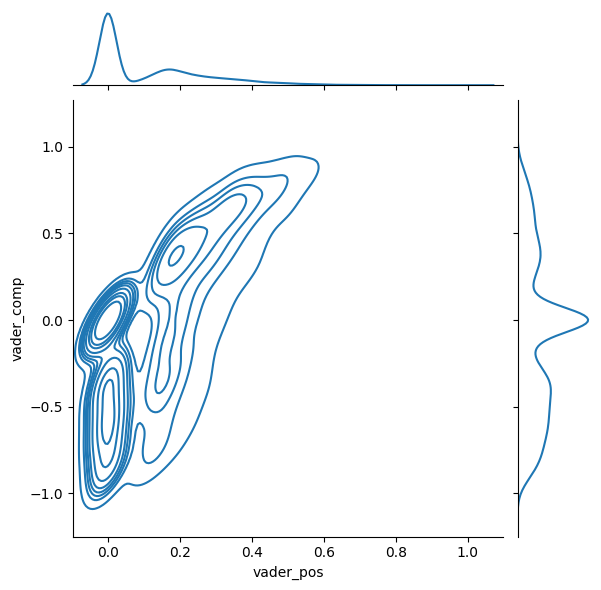

In [46]:
sns.jointplot(data=df_copy, x='vader_pos', y='vader_comp', kind="kde")

In [47]:
class0=[]
for i in range(len(df_copy)):
    if df_copy.loc[i,'vader_pos']>0.1:
        class0+=[2]
    elif df_copy.loc[i,'vader_neg']>0.1:
        class0+=[0]
    else:
        class0+=[1]

In [48]:
print(len(df))
print(len(df_copy))

11370
11370


In [49]:
df_copy['class']=class0
df_copy['class'].value_counts()

2    4931
0    3889
1    2550
Name: class, dtype: int64

# **Tokenize Sequences**


---


It tokenizes the input text into sequnences of intergers and then pad each sequence to the same length.


In [50]:
max_words = 5000
max_len=50

def tokenize_pad_sequences(text):

    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    X = tokenizer.texts_to_sequences(text)
    X = pad_sequences(X, padding='post', maxlen=max_len)
    return X, tokenizer

print('Before Tokenization & Padding \n', df['cleantext2'][0])
X, tokenizer = tokenize_pad_sequences(df['cleantext2'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 communal violence bhainsa telangana stones pelted muslims houses houses vehicles set ablaze 
After Tokenization & Padding 
 [4095  664 1520 1330 1840 4096  953  626  626 1217  166  836    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [51]:
print(X.shape)

(11370, 50)


# Training Model


In [52]:
y = pd.get_dummies(df['class'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

print('Train Set: ', X_train.shape, y_train.shape)
print('Validation Set: ', X_val.shape, y_val.shape)
print('Test Set: ', X_test.shape, y_test.shape)

Train Set:  (6822, 50) (6822, 3)
Validation Set:  (2274, 50) (2274, 3)
Test Set:  (2274, 50) (2274, 3)


In [54]:
def f1_score(precision, recall):
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [68]:
vocab_size = 5000
embedding_size = 32
epochs = 10
learning_rate = 0.1
decay_rate = 10
momentum = 0.8

optimizer = tf.keras.optimizers.legacy.SGD(lr=learning_rate, decay=decay_rate, momentum=momentum, nesterov=False)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [96]:
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

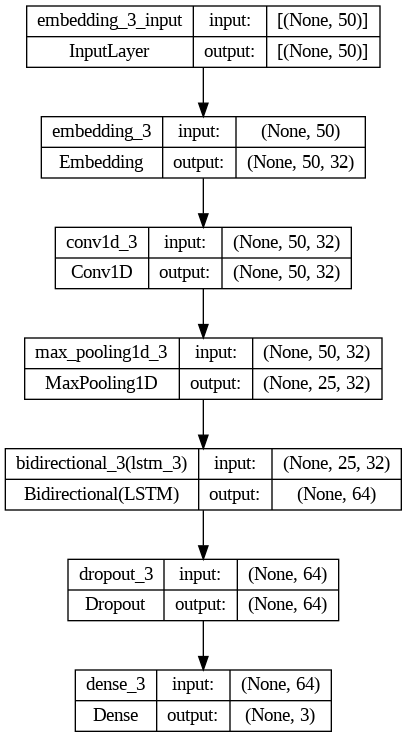

In [97]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [98]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', Precision(), Recall()])

In [99]:
history = model.fit(X_train,y_train,validation_data=(X_val, y_val),batch_size=16,epochs=epochs,verbose=1)

Epoch 1/10
427/427 [==============================] - 10s 17ms/step - loss: 1.0948 - accuracy: 0.4138 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 1.0947 - val_accuracy: 0.4230 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/10
427/427 [==============================] - 6s 15ms/step - loss: 1.0944 - accuracy: 0.4197 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 1.0945 - val_accuracy: 0.4230 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 3/10
427/427 [==============================] - 6s 14ms/step - loss: 1.0938 - accuracy: 0.4295 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 1.0943 - val_accuracy: 0.4230 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 4/10
427/427 [==============================] - 6s 13ms/step - loss: 1.0940 - accuracy: 0.4242 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 1.0941 - val_accuracy: 0.4230 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epo

# Evaluation


In [100]:
loss, accuracy, precision, recall = model.evaluate(X_train, y_train)

print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))

214/214 [==============================] - 1s 4ms/step - loss: 1.0928 - accuracy: 0.4351 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00
Accuracy  : 0.4351
Precision : 0.0000
Recall    : 0.0000
F1 Score  : 0.0000


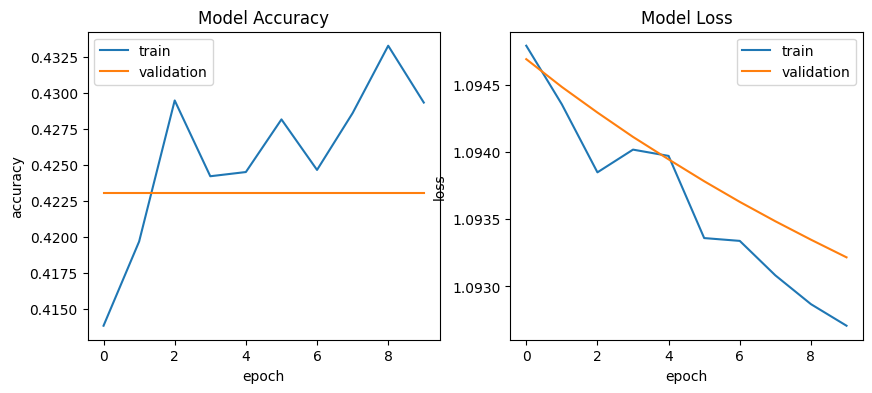

In [101]:
def plot_training_hist(history):
    fig, ax = plt.subplots(1,2, figsize=(10,4))

    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')

    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')

plot_training_hist(history)

72/72 [==============================] - 1s 3ms/step
2    1001
0     747
1     526
dtype: int64
2    2274
dtype: int64


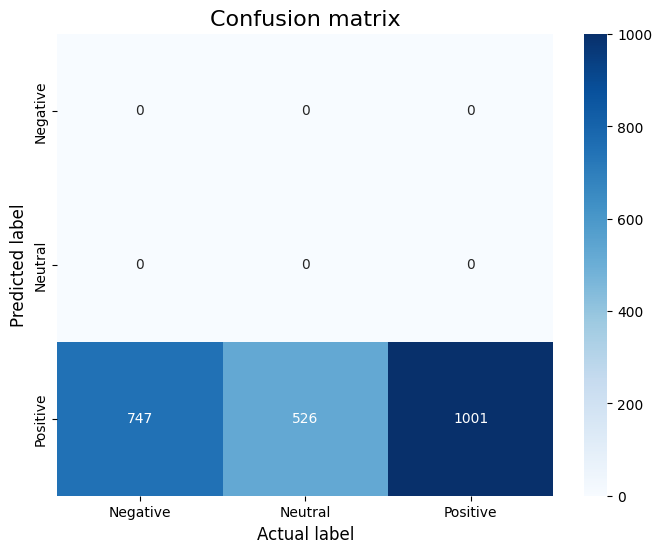

In [102]:
def plot_confusion_matrix(model, X_test, y_test):

    sentiment_classes =   ['Negative','Neutral', 'Positive']
    y_pred = model.predict(X_test)
    cm = confusion_matrix(np.argmax(y_pred, axis=1),np.argmax(np.array(y_test),axis=1))

    print(pd.Series(np.argmax(np.array(y_test),axis=1)).value_counts())
    print(pd.Series(np.argmax(y_pred, axis=1)).value_counts())

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)

plot_confusion_matrix(model, X_test, y_test)